# Exploratory Data Analysis (EDA)

## Import packages

In [1]:
import pandas as pd
import numpy as np
import textblob
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix
plt.style.use('fivethirtyeight')
from collections import Counter
import matplotlib
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Set files and folders

In [2]:
data_file = r'./Data/train.csv'
image_source = r'./Data/Images/data/competition_files/train_jpg'

## Read data

In [3]:
data = pd.read_csv(data_file)

In [6]:
print(data.shape)
print(data.loc[data.deal_probability>=0.5,:].shape)
print(data.loc[data.deal_probability<0.5,:].shape)

(1503424, 18)
(182013, 18)
(1321411, 18)


## Data dimension, type and nulls

In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503424 entries, 0 to 1503423
Data columns (total 18 columns):
item_id                 1503424 non-null object
user_id                 1503424 non-null object
region                  1503424 non-null object
city                    1503424 non-null object
parent_category_name    1503424 non-null object
category_name           1503424 non-null object
param_1                 1441848 non-null object
param_2                 848882 non-null object
param_3                 640859 non-null object
title                   1503424 non-null object
description             1387148 non-null object
price                   1418062 non-null float64
item_seq_number         1503424 non-null int64
activation_date         1503424 non-null object
user_type               1503424 non-null object
image                   1390836 non-null object
image_top_1             1390836 non-null float64
deal_probability        1503424 non-null float64
dtypes: float64(3), int

Check the distribution of object types across the data's columns.

In [105]:
g = data.columns.to_series().groupby(data.dtypes).groups
for k, v in g.items():
    print('Type:',k, '. Columns:', v, '\n')

Type: object . Columns: Index(['item_id', 'user_id', 'region', 'city', 'parent_category_name',
       'category_name', 'param_1', 'param_2', 'param_3', 'title',
       'description', 'activation_date', 'user_type', 'image'],
      dtype='object') 

Type: int64 . Columns: Index(['item_seq_number'], dtype='object') 

Type: float64 . Columns: Index(['price', 'image_top_1', 'deal_probability'], dtype='object') 



Check first 5 lines of the data.

In [106]:
data.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.00,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.00,0.13
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.00,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.00,0.00
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.00,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.00,0.43
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.00,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.00,0.80
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.00,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.00,0.21


The dataset is comprised of 1,503,424 ads with 18 columns. The columns hold different ad characteristics that range from numerical data (eg. price, image_top_1) to text objects (eg. title, description).  The text objects are expressed in the Russian language.

The last column (***deal_probability***) is the quantity to be forecasted (dependent variable).

Note that the dataset is augmented by images shown in the ads (the ***image*** column has the filename of the picture). The location of the images is in a separate folder. It would be interesting to check if an ad can have more than 1 image associated with it.

In [107]:
#Create list with the length of the image filename string. There could be 3 cases:
#The length expresses the number of characters in the filename.
#The length expresses the number of images associated with a specific ad (list of lists)
#The length is 0 as there are no images associated with the specific ad.
len_image = []
for i in data.image:
    if type(i) == str:
        len_image.append(len(i))
    else:
        len_image.append(0)

In [108]:
#Check unique entries in len_image object and count occurrences of each unique value
print('Unique elements in len_image: ',Counter(len_image).keys())
print('Counts of unique elements in len_image: ',Counter(len_image).values())

Unique elements in len_image:  dict_keys([64, 0])
Counts of unique elements in len_image:  dict_values([1390836, 112588])


Out of 1,503,424 ads, 1,390,836 of them have one photo (in the main table there's a 64 character filename corresponding to the ad's image) and 112,588 do not have a photo.

Examples of ad photos.

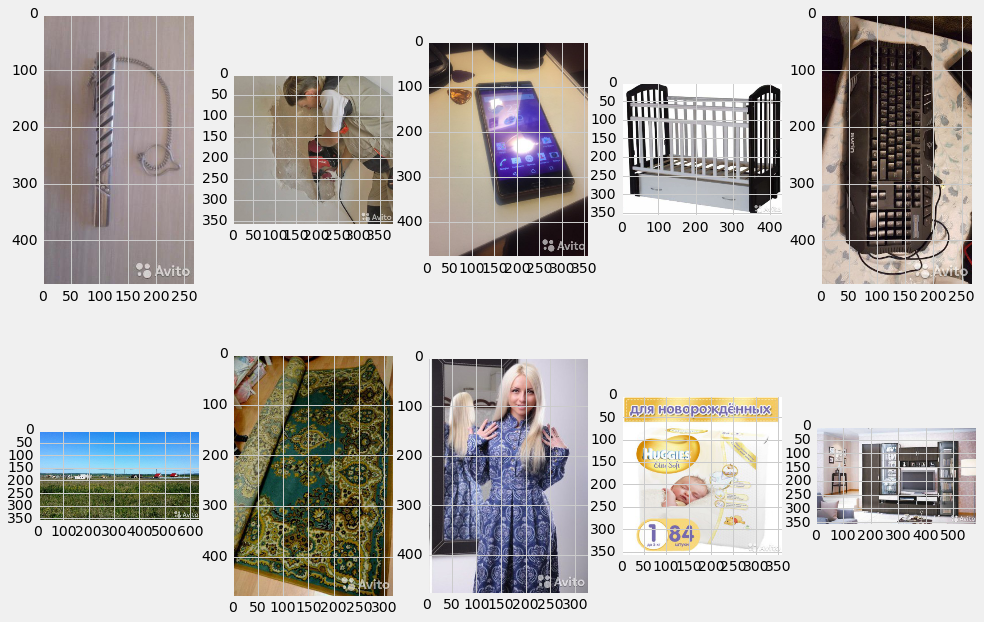

In [109]:
np.random.seed(100)
fig=plt.figure(figsize=(15, 10))
rows = 2
columns = 5
for i in range(1, columns*rows+1):
    img = Image.open(image_source+'/'+data.image[np.random.randint(data.shape[0])]+'.jpg','r')
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.asarray(img));

## Distribution of *deal_probability*

In [110]:
data.deal_probability.describe()

count   1503424.00
mean          0.14
std           0.26
min           0.00
25%           0.00
50%           0.00
75%           0.15
max           1.00
Name: deal_probability, dtype: float64

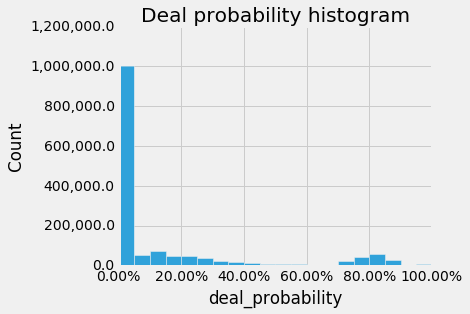

In [111]:
ax = data.deal_probability.hist(bins=20, figsize=(5,4));
plt.xlabel('deal_probability');
plt.ylabel('Count');
plt.title('Deal probability histogram');
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: '{:.2%}'.format(x)))
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(x, ',')))

In [112]:
zero_count = sum(data.deal_probability==0)
zero_prop = zero_count/data.shape[0]
print('Number of records where deal_probability is zero = ','{:,}'.format(zero_count),'\n','Proportion of records where deal_probability is zero = ',  '{:.2%}'.format(zero_prop))

Number of records where deal_probability is zero =  974,618 
 Proportion of records where deal_probability is zero =  64.83%


Note that the majority of the records have a deal probability of zero. In fact, 974,618 records (or 64.83% of the data) has a deal probability of zero.

This is a highly unbalanced dataset, and the evaluation metric on the supervised classification approach was chosen to be the F1-Score as it is a more balanced approach to evaluate the model. The F1-Score is the harmonic mean between precision and recall, which means that it will be more influenced by a low value in either precision or recall. A naive model that only predicts positive labels, will have many False Positives, and hence low precision and high recall. Also, an equally naive model that only predicts negative labels, will have many False Negatives, and hence low recall and high precision. In both cases the F1-Score would be heavily influenced by the low scores on one of the metrics.

## Data breakdown across categorical variables

### Region

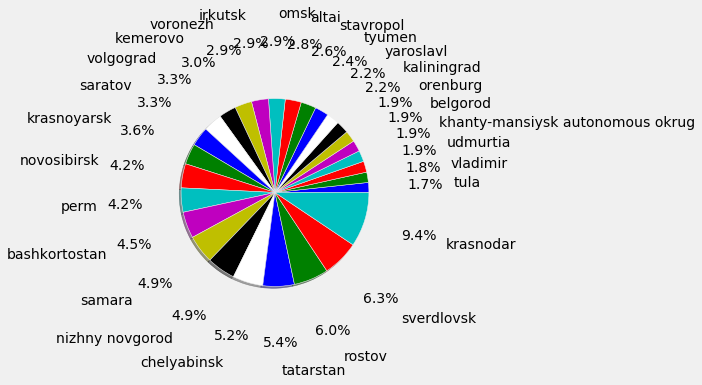

In [113]:
#Get unique regions
regions = list(data.region.unique())
#Count regions across all data records
region_count = data.groupby(['region']).count()['item_id'].copy()
region_count.sort_values(inplace = True)
#Get region proportion
region_percent = region_count / region_count.sum()
#Reindex so that English names appear in the pie chart
regions_eng = [str(textblob.TextBlob(x).translate(to = 'en')).lower().replace('region','').strip() for x in regions]
region_translation = dict(zip(regions, regions_eng))
region_percent.rename(region_translation, inplace = True)
#Plot pie chart with proportion of regions in the dataset
plt.figure(figsize = (3,5));
plt.pie(region_percent, labels = region_percent.index, shadow = True, autopct = '%1.1f%%', startangle = 0, pctdistance = 1.6, labeldistance = 1.9);
plt.axis('equal');

The ads are fairly diversified across regions with the largest concentration at 9.4% in the Krasnodar region.

In [114]:
regions_deal_stats = data.groupby(['region'])['deal_probability'].describe()
regions_deal_stats.rename(region_translation, inplace = True)
regions_deal_stats.sort_values(by = ['mean'], ascending = False, inplace =True)
regions_deal_stats

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
orenburg,29303.00,0.16,0.27,0.00,0.00,0.00,0.20,1.00
stavropol,39187.00,0.15,0.26,0.00,0.00,0.00,0.20,1.00
bashkortostan,68291.00,0.15,0.26,0.00,0.00,0.00,0.19,1.00
udmurtia,28537.00,0.15,0.26,0.00,0.00,0.00,0.17,1.00
krasnodar,141416.00,0.15,0.26,0.00,0.00,0.00,0.18,1.00
nizhny novgorod,73643.00,0.15,0.27,0.00,0.00,0.00,0.16,1.00
saratov,49645.00,0.15,0.26,0.00,0.00,0.00,0.18,1.00
volgograd,48998.00,0.15,0.27,0.00,0.00,0.00,0.16,1.00
belgorod,28868.00,0.15,0.26,0.00,0.00,0.00,0.17,1.00


In all of the regions, more than 50% of deal probabilities are zero. Furthermore, the maximum 75th percentile across regions is 20%, which is a fairly low probability.
Looking at these numbers it seems that a lot of deals do not go through completion.
At the region level, the average deal probability is within a somewhat compressed range (12.04% to 15.59%).

### City

In [115]:
#Get unique cities
cities = list(data.city.unique())
#Count cities across all data records
city_count = data.groupby(['city']).count()['item_id'].copy()
city_count.sort_values(inplace = True)
#Get city proportion
city_percent = city_count / city_count.sum()
print('There are a total of ',len(cities),' unique cities. The least represented city is ',str(textblob.TextBlob(city_percent.idxmin()).translate(to = 'en')).strip(),' with ','{:.2%}'.format(city_percent.min()), 'and the most represented city is ',str(textblob.TextBlob(city_percent.idxmax()).translate(to = 'en')).strip(),' with' ,'{:.2%}'.format(city_percent.max()))

There are a total of  1733  unique cities. The least represented city is  Eagle-Emerald  with  0.00% and the most represented city is  Krasnodar  with 4.23%


Given the widespread distribution of ads per cities across 1733 cities, it is more relevant to aggregate data per region.

### Parent Category

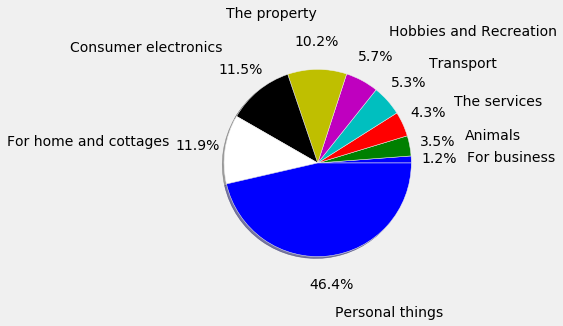

In [116]:
#Get unique parent category
parent_categories = list(data.parent_category_name.unique())
#Count parent categories across all data records
parent_category_count = data.groupby(['parent_category_name']).count()['item_id'].copy()
parent_category_count.sort_values(inplace = True)
#Get parent category proportion
parent_category_percent = parent_category_count / parent_category_count.sum()
#Reindex so that English names appear in the pie chart
parent_category_eng = [str(textblob.TextBlob(x).translate(to = 'en')).strip() for x in parent_categories]
parent_category_translation = dict(zip(parent_categories, parent_category_eng))
parent_category_percent.rename(parent_category_translation, inplace = True)
#Plot pie chart with proportion of parent categories in the dataset
plt.figure(figsize = (3,5));
plt.pie(parent_category_percent, labels = parent_category_percent.index, shadow = True, autopct = '%1.1f%%', startangle = 0, pctdistance = 1.3, labeldistance = 1.6);
plt.axis('equal');

Ads are concentrated in the *Personal things* category, with about 46% of all ads.

In [117]:
parent_cat_deal_stats = data.groupby(['parent_category_name'])['deal_probability'].describe()
parent_cat_deal_stats.rename(parent_category_translation, inplace = True)
parent_cat_deal_stats.sort_values(by = ['mean'], ascending = False, inplace =True)
parent_cat_deal_stats

,count,mean,std,min,25%,50%,75%,max
parent_category_name,,,,,,,,
The services,64385.00,0.40,0.35,0.00,0.14,0.33,0.60,1.00
Transport,79839.00,0.26,0.29,0.00,0.00,0.13,0.48,0.74
Animals,52470.00,0.24,0.29,0.00,0.00,0.11,0.38,0.79
For home and cottages,178823.00,0.18,0.31,0.00,0.00,0.00,0.22,0.87
Consumer electronics,173008.00,0.18,0.28,0.00,0.00,0.00,0.25,0.77
The property,153190.00,0.14,0.19,0.00,0.00,0.07,0.19,1.00
Hobbies and Recreation,86011.00,0.12,0.26,0.00,0.00,0.00,0.10,0.83
For business,18075.00,0.11,0.22,0.00,0.00,0.00,0.12,0.79
Personal things,697623.00,0.08,0.21,0.00,0.00,0.00,0.00,0.80


A more interesting picture emerges from looking at the data through the *parent_category_name* column:

* "The services" parent category is characterized by the largest mean deal probability (40%).
* "Personal things" parent category is the most frequent parent category in the dataset but it has the lowest average deal probability (7.59%).
* The intermediate parent categories (in terms of deal probability) are concentrated in a fairly narrow range (11.10% to 26.33%).

The *parent_category_name* feature has some potential in separating high vs. low deal probaiblity ads.

### Category

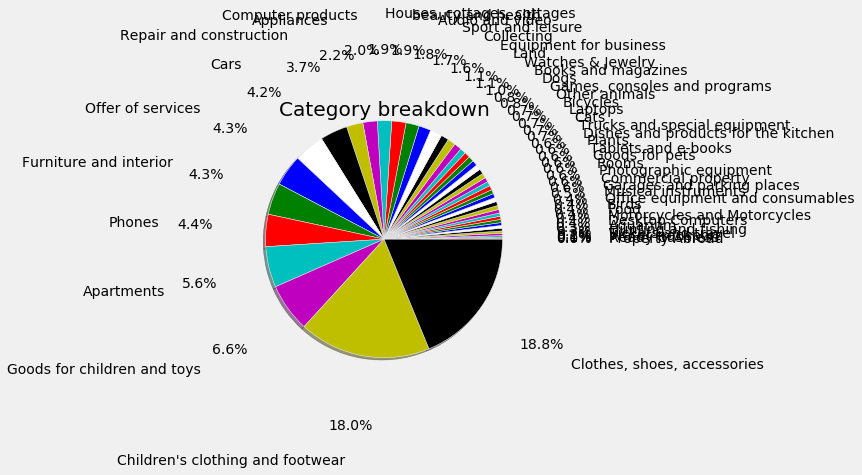

In [118]:
#Get unique categories
categories = list(data.category_name.unique())
#Count categories across all data records
category_count = data.groupby(['category_name']).count()['item_id'].copy()
category_count.sort_values(inplace = True)
#Get category proportion
category_percent = category_count / category_count.sum()
#Reindex so that English names appear in the pie chart
category_eng = [str(textblob.TextBlob(x).translate(to = 'en')).strip() for x in categories]
category_translation = dict(zip(categories, category_eng))
category_percent.rename(category_translation, inplace = True)
#Plot pie chart with proportion of categories in the dataset
plt.pie(category_percent, labels = category_percent.index, shadow = True, autopct = '%1.1f%%', startangle = 0, pctdistance = 1.6, labeldistance = 1.9);
plt.axis('equal');
plt.title('Category breakdown');

In [119]:
cat_deal_stats = data.groupby(['category_name'])['deal_probability'].describe()
cat_deal_stats.rename(category_translation, inplace = True)
cat_deal_stats.sort_values(by = ['mean'], ascending = False, inplace =True)
cat_deal_stats

,count,mean,std,min,25%,50%,75%,max
category_name,,,,,,,,
Offer of services,64385.00,0.40,0.35,0.00,0.14,0.33,0.60,1.00
Cats,9951.00,0.30,0.31,0.00,0.00,0.19,0.69,0.79
Cars,62494.00,0.28,0.30,0.00,0.00,0.15,0.63,0.74
Other animals,11040.00,0.26,0.28,0.00,0.00,0.19,0.39,0.79
Dogs,11612.00,0.25,0.29,0.00,0.00,0.14,0.39,0.79
Appliances,33705.00,0.25,0.36,0.00,0.00,0.00,0.44,0.87
Motorcycles and Motorcycles,5771.00,0.25,0.29,0.00,0.00,0.11,0.48,0.74
Bicycles,10638.00,0.25,0.35,0.00,0.00,0.00,0.59,0.83
Birds,6447.00,0.24,0.26,0.00,0.00,0.20,0.39,0.79


The *category_name* feature allows for a more detailed dive on the *parent_category_name* and show some interesting dynamics in terms of *deal_probability*:

* "The services" does not have a more detailed breakdown.
* "Animals" ranks 3rd in terms of average deal probability within the *parent_category_name* filter (26.60%). However, the sub-categories have a somewhat wide dispersion of average deal probabilities (eg. "Cats" with 29.73% and "Goods for pets" with 13.36%).

I think it is best to focus on *category_name* as it gives a more thorough information "richness". However, if model performance becomes an issue, then *parent_category_name* could be used instead.

### Activation date

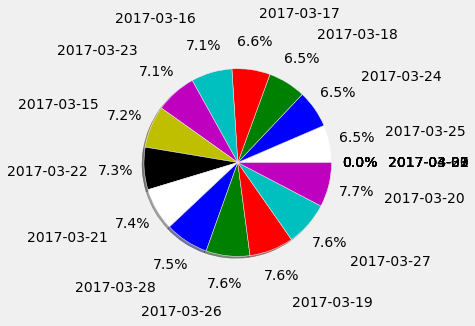

In [120]:
#Get unique activation dates
activation_dates = list(data.activation_date.unique())
#Count activation dates across all data records
activation_dates_count = data.groupby(['activation_date']).count()['item_id'].copy()
activation_dates_count.sort_values(inplace = True)
#Get activation dates proportion
activation_dates_percent = activation_dates_count / activation_dates_count.sum()
#Plot pie chart with proportion of activation dates in the dataset
plt.figure(figsize = (3,5));
plt.pie(activation_dates_percent, labels = activation_dates_percent.index, shadow = True, autopct = '%1.1f%%', startangle = 0, pctdistance = 1.3, labeldistance = 1.6);
plt.axis('equal');

The distribution of ads per activation date is very close to an equal weight (1/unique dates), with the exception of the latest 7 days in the dataset (from 2017-03-29 onwards) where a low number of ads are present.

In [121]:
date_deal_stats = data.groupby(['activation_date'])['deal_probability'].describe()
date_deal_stats

,count,mean,std,min,25%,50%,75%,max
activation_date,,,,,,,,
2017-03-15,108615.00,0.14,0.26,0.00,0.00,0.00,0.16,1.00
2017-03-16,106168.00,0.14,0.26,0.00,0.00,0.00,0.16,1.00
2017-03-17,98773.00,0.14,0.26,0.00,0.00,0.00,0.16,1.00
2017-03-18,97554.00,0.14,0.26,0.00,0.00,0.00,0.15,1.00
2017-03-19,114416.00,0.14,0.26,0.00,0.00,0.00,0.14,1.00
2017-03-20,115190.00,0.14,0.26,0.00,0.00,0.00,0.15,1.00
2017-03-21,110535.00,0.14,0.26,0.00,0.00,0.00,0.15,1.00
2017-03-22,109813.00,0.14,0.26,0.00,0.00,0.00,0.15,1.00
2017-03-23,106544.00,0.14,0.26,0.00,0.00,0.00,0.15,1.00


Even though there are days where deal probability is extremely high, it occurs in situations where sample size is very low. A weekday vs. weekend feature might be thought of as something that would differentiate deal probability across activation dates, but it would not be a very robust rule to look at (eg. 2017-04-01 had an average 80.32% deal probability but only 3 deals).

### User type

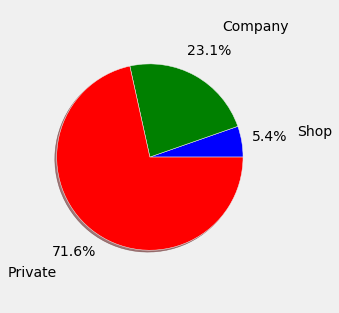

In [122]:
#Get unique user types
user_types = list(data.user_type.unique())
#Count user types across all data records
user_types_count = data.groupby(['user_type']).count()['item_id'].copy()
user_types_count.sort_values(inplace = True)
#Get user types proportion
user_types_percent = user_types_count / user_types_count.sum()
#Plot pie chart with proportion of user types in the dataset
plt.figure(figsize = (3,5));
plt.pie(user_types_percent, labels = user_types_percent.index, shadow = True, autopct = '%1.1f%%', startangle = 0, pctdistance = 1.3, labeldistance = 1.6);
plt.axis('equal');

The data is clearly dominated by the "Private" user type as opposed to professional user types like "Company" or "Shop".

In [123]:
user_type_deal_stats = data.groupby(['user_type'])['deal_probability'].describe()
user_type_deal_stats.sort_values(by = ['mean'], ascending = False, inplace =True)
user_type_deal_stats

,count,mean,std,min,25%,50%,75%,max
user_type,,,,,,,,
Private,1075706.00,0.15,0.27,0.00,0.00,0.00,0.18,1.00
Company,347249.00,0.12,0.25,0.00,0.00,0.00,0.13,1.00
Shop,80469.00,0.06,0.15,0.00,0.00,0.00,0.05,1.00


Surprisingly, the average deal probability of the "Private" user type is the highest at 14.96%. My expectation was that professional users like "Company" and "Shop" would post higher quality ads positioned in front of the website as to increase deal probability, but this does not appear to be the case.

It is also interesting to note that the "Shop" category type has a low average deal probability (6.28%). This might be explained by many items sold by "Private" user types being second hand, and hence, having a lower price relative to the "Shop" user price.

## Continuous variables: *price*, *image_top_1*, and *item_seq_number*.

In [124]:
data.loc[:,['price','image_top_1','item_seq_number']].describe()

,price,image_top_1,item_seq_number
count,1418062.00,1390836.00,1503424.00
mean,316708.09,1241.93,743.67
std,66891542.10,970.46,5572.52
min,0.00,0.00,1.00
25%,500.00,425.00,9.00
50%,1300.00,1057.00,29.00
75%,7000.00,2217.00,88.00
max,79501011850.00,3066.00,204429.00


It is interesting to see that not all ads have a price (*price* count is different than total number of rows in dataset).
The *price* variable is heavily influenced by extreme outliers (see the 'max' row and how the standard deviation is much greater than the mean value).

The *image_top_1* variable has as many counts as there are ad images, as expected (1,390,836).

In order to conveniently represent the *price* information in a histogram, a log transformation is made so that the range of values is more compressed.

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


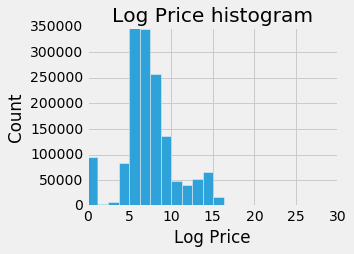

In [128]:
ax = np.log(data.price);
ax.fillna(0, inplace = True);
ax.replace(-np.inf,0, inplace = True);
ax.hist(bins = 20,figsize=(4,3));
plt.xlabel('Log Price');
plt.ylabel('Count');
plt.title('Log Price histogram');

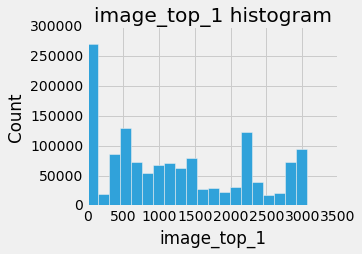

In [129]:
ax = data.image_top_1.hist(bins=20, figsize=(4,3));
plt.xlabel('image_top_1');
plt.ylabel('Count');
plt.title('image_top_1 histogram');

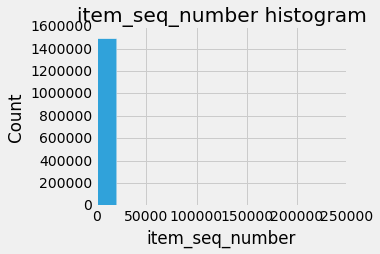

In [130]:
ax = data.item_seq_number.hist(bins=10, figsize=(4,3));
plt.xlabel('item_seq_number');
plt.ylabel('Count');
plt.title('item_seq_number histogram');

## Outliers

From the *price* distribution plot above, it is clear that there are outliers in the data.
A common and reasonable approach to handle outliers is to remove records which have the *price* above (below) 1.5 times the inter-quartile range from Q3 (Q1).

In [134]:
Q3, Q1 = np.percentile(data.price.dropna(), [75, 25])
IQR = Q3 - Q1
lower_bound = np.max([Q1 - IQR*1.5, 0])#Price cannot be negative
upper_bound = Q3 + IQR*1.5

In [135]:
data['Outlier'] = 0
data.loc[data.price > upper_bound, ['Outlier']] = 1
data.loc[data.price < lower_bound, ['Outlier']] = 1

In [136]:
pd.DataFrame({'Counts':data.Outlier.value_counts(),'Proportion':data.Outlier.value_counts()/data.shape[0]})

,Counts,Proportion
0,1256158,0.84
1,247266,0.16


In [137]:
data = data.loc[data.Outlier == 0,:].copy()

## Behavior of deal_probability across continuous variables

### Price

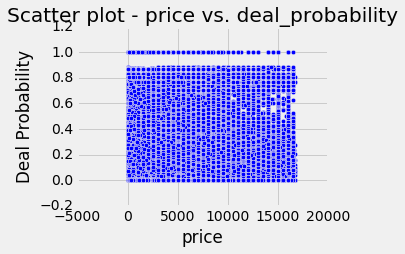

In [139]:
plt.figure(figsize = (4,3));
plt.scatter(x = data.price, y = data.deal_probability);
plt.ylabel('Deal Probability');
plt.xlabel('price');
plt.title('Scatter plot - price vs. deal_probability');

### image_top_1

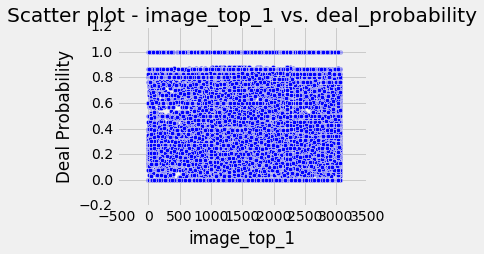

In [140]:
plt.figure(figsize = (4,3));
plt.scatter(x = data.image_top_1, y = data.deal_probability);
plt.ylabel('Deal Probability');
plt.xlabel('image_top_1');
plt.title('Scatter plot - image_top_1 vs. deal_probability');

### item_seq_number

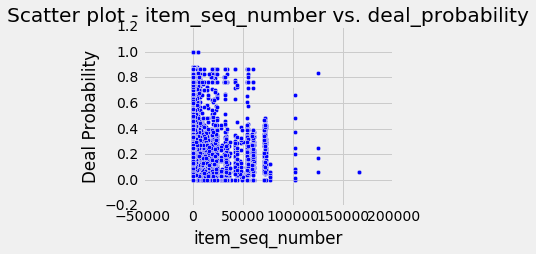

In [141]:
plt.figure(figsize = (4,3));
plt.scatter(x = data.item_seq_number, y = data.deal_probability);
plt.ylabel('Deal Probability');
plt.xlabel('item_seq_number');
plt.title('Scatter plot - item_seq_number vs. deal_probability');

The scatter plots above do not show a clear linear relationship between either *price*, *image_top_1*, or *item_seq_number* with *deal_probability*.

However, it is interesting to note three characteristics:

1. The *price* variable at high values has less points on the upper range of *deal_probability*. Notice how the number of points in the upper range of *deal_probability* decays (points become scarce) as price increases.

2. Looking at *item_seq_number*, there appears to be a somewhat concave relationship, ie, the higher the *item_seq_number* , the more narrow is the range of the *deal_probability* variable towards lower values.

3. There is a gap on the *deal_probability* variable from values around 0.9 to 1.0 (in all variables).

## Correlation matrix between continuous variables 

In [77]:
data.loc[~(pd.isnull(data.price) | pd.isnull(data.image_top_1) | pd.isnull(data.item_seq_number)) ,['price', 'image_top_1', 'item_seq_number', 'deal_probability']].corr()

,price,image_top_1,item_seq_number,deal_probability
price,1.00,0.33,0.06,0.09
image_top_1,0.33,1.00,0.09,0.21
item_seq_number,0.06,0.09,1.00,-0.02
deal_probability,0.09,0.21,-0.02,1.00


The only noteworthy aspect of the linear correlations is that the *image_top_1* variable has the largest postive correlation with *deal_probability* (0.21). This variable might be a quantitative metric of image quality, as the better the image quality, the higher the likelyhood that a deal occurs.

## Ads with no price

In [78]:
data.loc[pd.isnull(data.price),'deal_probability'].describe()

count   85362.00
mean        0.22
std         0.28
min         0.00
25%         0.00
50%         0.11
75%         0.33
max         1.00
Name: deal_probability, dtype: float64

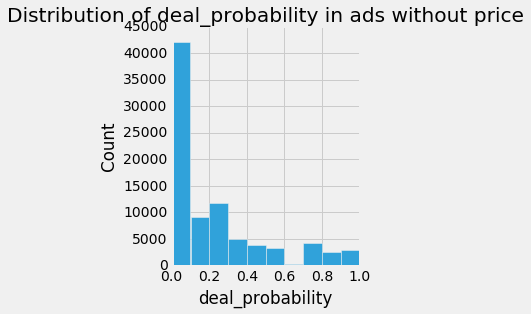

In [142]:
ax = data.loc[pd.isnull(data.price),'deal_probability'].hist(bins=10, figsize=(3,4));
plt.title('Distribution of deal_probability in ads without price');
plt.ylabel('Count');
plt.xlabel('deal_probability');

There are 85,362 ads without price. The distribution of *deal_probability* among those ads is fairly wide, and it is counterintuitive, as I was expecting that the absence of a price would correspond to either an extremely high likely hood of the deal to occur (free item) or an extremely low likelihood (invalid ad without the *price* information).

Although it is true that the majority of ads without price have a zero *deal_probability* value, it is not the majority of cases.

Given the points made above, I think it is best to remove records with no *price* information.

In [80]:
#Number of ads without price
data.loc[pd.isnull(data.price),'deal_probability'].shape

(85362,)

In [81]:
#Number of ads without price and zero deal_probability
data.loc[(pd.isnull(data.price)) & (data.deal_probability == 0),'deal_probability'].shape

(36751,)

In [82]:
data = data.loc[~pd.isnull(data.price),:].copy()

Next step in the analysis is to do feature engineering using both the table and image data. This is done in the "Feature Engineering.ipynb" file. The cleaned (ex-outliers and ex-null *price*) dataset is outputed so it can be processed in the next stage.

In [48]:
#Save csv with cleaned dataset
data.to_csv(r'./Data/cleaned_train.csv', index = False)